In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 

In [31]:
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [106]:
df = pd.read_csv('../click_fraud_dataset.csv')
df.head()

,click_id,timestamp,user_id,ip_address,device_type,browser,operating_system,referrer_url,page_url,click_duration,...,mouse_movement,keystrokes_detected,ad_position,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,bot_likelihood_score,is_fraudulent
0,d875835d-3a4a-4a20-b0d1-6cddf89afc6a,2024-08-23 02:47:39,65a2f621-707b-49be-9c3e-ccac0b1d89ef,141.36.49.37,Tablet,Safari,Android,https://evans-ford.com/,http://www.turner-stewart.com/,0.29,...,111,8,Bottom,7,72,Good,0,1,0.29,0
1,a2d3f028-7790-4be1-9f75-df1357edbbdb,2025-01-30 23:23:50,135e0114-76c5-43ea-bdef-80ab537dc009,216.29.19.201,Desktop,Opera,iOS,https://pierce-ferguson.net/,http://www.rodriguez.biz/,0.64,...,452,29,Bottom,9,201,Suspicious,0,0,0.74,0
2,36d787b2-fbce-43ef-8c02-7c8746d7e3db,2025-01-21 05:41:12,a6922984-78cb-4c01-9c88-bfe3a13a0aaf,167.133.41.231,Tablet,Safari,Linux,https://www.martinez.com/,https://beck.biz/,0.42,...,431,18,Bottom,9,326,Good,0,1,0.14,0
3,01fc0078-096b-4f90-82ae-aa8085b719ac,2024-10-12 08:18:14,d30788b2-4048-4770-a4b1-a9358788818f,216.146.33.78,Tablet,Edge,macOS,https://jones-mendoza.com/,https://www.alvarado.com/,4.29,...,472,37,Side,4,33,Suspicious,0,0,0.65,0
4,0afdf2af-0b48-47d5-bfb6-e087053e1eb9,2024-04-19 14:44:35,dfc42287-6325-4344-b373-b8e61ea6e5c1,146.37.54.245,Desktop,Opera,Windows,https://www.griffith-holloway.com/,http://gonzalez.com/,2.46,...,50,2,Side,7,97,Good,0,0,0.06,0


Drop irrelevant columns

In [107]:
# Remove IDs, timestamps, and URLs (not useful for training)
drop_cols = [
    "click_id", "timestamp", "user_id", "referrer_url", "page_url", "ad_position", "bot_likelihood_score"
]
df = df.drop(columns=drop_cols)

df.head()

,ip_address,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,is_fraudulent
0,141.36.49.37,Tablet,Safari,Android,0.29,60,111,8,7,72,Good,0,1,0
1,216.29.19.201,Desktop,Opera,iOS,0.64,25,452,29,9,201,Suspicious,0,0,0
2,167.133.41.231,Tablet,Safari,Linux,0.42,36,431,18,9,326,Good,0,1,0
3,216.146.33.78,Tablet,Edge,macOS,4.29,29,472,37,4,33,Suspicious,0,0,0
4,146.37.54.245,Desktop,Opera,Windows,2.46,94,50,2,7,97,Good,0,0,0


In [108]:
import geoip2.database

city_db = "GeoLite2/GeoLite2-City.mmdb"
asn_db = "GeoLite2/GeoLite2-ASN.mmdb"

reader_city = geoip2.database.Reader(city_db)
reader_asn = geoip2.database.Reader(asn_db)

def enrich_ip(ip):
    data = {
        "ip_country": None,
        "ip_city": None,
        "ip_asn": None,
        "ip_org": None,
        "ip_is_datacenter": 0
    }
    try:
        city = reader_city.city(ip)
        asn = reader_asn.asn(ip)

        data["ip_country"] = city.country.name
        data["ip_city"] = city.city.name
        data["ip_asn"] = asn.autonomous_system_number
        data["ip_org"] = asn.autonomous_system_organization

        # crude datacenter detection
        dc_keywords = ['Amazon', 'Google', 'OVH', 'Microsoft', 'DigitalOcean', 'Hetzner', 'Linode']
        if any(k in (asn.autonomous_system_organization or "") for k in dc_keywords):
            data["ip_is_datacenter"] = 1
    except Exception:
        pass
    return pd.Series(data)


In [109]:
# Example use:
ip_info = enrich_ip("203.94.72.111")
print(ip_info)

ip_country                           Sri Lanka
ip_city                                Colombo
ip_asn                                    9329
ip_org              Sri Lanka Telecom Internet
ip_is_datacenter                             0
dtype: object


In [110]:
df = df.join(df['ip_address'].apply(enrich_ip))
df.head()

,ip_address,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,is_fraudulent,ip_country,ip_city,ip_asn,ip_org,ip_is_datacenter
0,141.36.49.37,Tablet,Safari,Android,0.29,60,111,8,7,72,Good,0,1,0,NaN,NaN,NaN,NaN,0.0
1,216.29.19.201,Desktop,Opera,iOS,0.64,25,452,29,9,201,Suspicious,0,0,0,United States,None,174.0,COGENT-174,0.0
2,167.133.41.231,Tablet,Safari,Linux,0.42,36,431,18,9,326,Good,0,1,0,NaN,NaN,NaN,NaN,0.0
3,216.146.33.78,Tablet,Edge,macOS,4.29,29,472,37,4,33,Suspicious,0,0,0,United States,Ashburn,31898.0,ORACLE-BMC-31898,0.0
4,146.37.54.245,Desktop,Opera,Windows,2.46,94,50,2,7,97,Good,0,0,0,NaN,NaN,NaN,NaN,0.0


In [111]:
from user_agents import parse

def parse_user_agent(ua_str):
    try:
        ua = parse(ua_str)
        return pd.Series({
            "ua_browser": ua.browser.family,
            "ua_os": ua.os.family,
            "ua_device": ua.device.family,
            "ua_is_mobile": ua.is_mobile,
            "ua_is_tablet": ua.is_tablet,
            "ua_is_pc": ua.is_pc,
            "ua_is_bot": ua.is_bot
        })
    except Exception:
        return pd.Series({
            "ua_browser": None,
            "ua_os": None,
            "ua_device": None,
            "ua_is_mobile": False,
            "ua_is_tablet": False,
            "ua_is_pc": False,
            "ua_is_bot": False
        })

# Example:
ua_info = parse_user_agent("Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/117.0.0.0 Safari/537.36")
print(ua_info)


ua_browser       Chrome
ua_os           Windows
ua_device         Other
ua_is_mobile      False
ua_is_tablet      False
ua_is_pc           True
ua_is_bot         False
dtype: object


In [112]:
import ipaddress

def is_private_ip(ip):
    try:
        return ipaddress.ip_address(ip).is_private
    except:
        return False

def fraud_score(row):
    score = 0

    # 1️⃣ IP-based
    if row.get("ip_is_datacenter") == 1:
        score += 3
    if is_private_ip(row.get("ip_address", "")):
        score += 2
    if row.get("VPN_usage") == 1 or row.get("proxy_usage") == 1:
        score += 2

    # 2️⃣ Device & OS mismatch
    os = str(row.get("operating_system", "")).lower()
    browser = str(row.get("browser", "")).lower()
    device = str(row.get("device_type", "")).lower()

    if "windows" in os and "safari" in browser:
        score += 2
    if device == "mobile" and row.get("mouse_movement", 0) > 0:
        score += 1

    # 3️⃣ User-agent analysis (if parsed)
    if row.get("ua_is_bot", False):
        score += 4

    # 4️⃣ Behavior
    if row.get("click_duration", 10) < 1.0:
        score += 1

    return score

# Apply to dataset
df["fraud_score"] = df.apply(fraud_score, axis=1)

# Decide labels
df["predicted_label"] = (df["fraud_score"] >= 4).astype(int)  # 1=fraudulent, 0=genuine

df[["ip_address", "ip_country", "device_type", "browser", "operating_system", "fraud_score", "predicted_label"]].head()


,ip_address,ip_country,device_type,browser,operating_system,fraud_score,predicted_label
0,141.36.49.37,NaN,Tablet,Safari,Android,3,0
1,216.29.19.201,United States,Desktop,Opera,iOS,1,0
2,167.133.41.231,NaN,Tablet,Safari,Linux,3,0
3,216.146.33.78,United States,Tablet,Edge,macOS,0,0
4,146.37.54.245,NaN,Desktop,Opera,Windows,0,0


In [113]:
df.head()

,ip_address,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,...,VPN_usage,proxy_usage,is_fraudulent,ip_country,ip_city,ip_asn,ip_org,ip_is_datacenter,fraud_score,predicted_label
0,141.36.49.37,Tablet,Safari,Android,0.29,60,111,8,7,72,...,0,1,0,NaN,NaN,NaN,NaN,0.0,3,0
1,216.29.19.201,Desktop,Opera,iOS,0.64,25,452,29,9,201,...,0,0,0,United States,None,174.0,COGENT-174,0.0,1,0
2,167.133.41.231,Tablet,Safari,Linux,0.42,36,431,18,9,326,...,0,1,0,NaN,NaN,NaN,NaN,0.0,3,0
3,216.146.33.78,Tablet,Edge,macOS,4.29,29,472,37,4,33,...,0,0,0,United States,Ashburn,31898.0,ORACLE-BMC-31898,0.0,0,0
4,146.37.54.245,Desktop,Opera,Windows,2.46,94,50,2,7,97,...,0,0,0,NaN,NaN,NaN,NaN,0.0,0,0


In [114]:
# Convert all ASN values to string and fill NaN with "Unknown"
df["ip_asn"] = df["ip_asn"].astype(str).fillna("Unknown")

# Optional: Clean numeric-only ASNs (make them consistent like 'AS12345')
df["ip_asn"] = df["ip_asn"].apply(lambda x: f"AS{x}" if x.isdigit() else x)
df.head()


,ip_address,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,...,VPN_usage,proxy_usage,is_fraudulent,ip_country,ip_city,ip_asn,ip_org,ip_is_datacenter,fraud_score,predicted_label
0,141.36.49.37,Tablet,Safari,Android,0.29,60,111,8,7,72,...,0,1,0,NaN,NaN,nan,NaN,0.0,3,0
1,216.29.19.201,Desktop,Opera,iOS,0.64,25,452,29,9,201,...,0,0,0,United States,None,174.0,COGENT-174,0.0,1,0
2,167.133.41.231,Tablet,Safari,Linux,0.42,36,431,18,9,326,...,0,1,0,NaN,NaN,nan,NaN,0.0,3,0
3,216.146.33.78,Tablet,Edge,macOS,4.29,29,472,37,4,33,...,0,0,0,United States,Ashburn,31898.0,ORACLE-BMC-31898,0.0,0,0
4,146.37.54.245,Desktop,Opera,Windows,2.46,94,50,2,7,97,...,0,0,0,NaN,NaN,nan,NaN,0.0,0,0


In [116]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
label_encoders = {}
for col in ["device_type", "browser", "operating_system", "device_ip_reputation", "ip_country", "ip_city", "ip_asn", "ip_org"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.head()

,ip_address,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,...,VPN_usage,proxy_usage,is_fraudulent,ip_country,ip_city,ip_asn,ip_org,ip_is_datacenter,fraud_score,predicted_label
0,141.36.49.37,2,4,0,0.29,60,111,8,7,72,...,0,1,0,122,1417,1227,1147,0.0,3,0
1,216.29.19.201,0,3,3,0.64,25,452,29,9,201,...,0,0,0,117,1416,251,179,0.0,1,0
2,167.133.41.231,2,4,1,0.42,36,431,18,9,326,...,0,1,0,122,1417,1227,1147,0.0,3,0
3,216.146.33.78,2,1,4,4.29,29,472,37,4,33,...,0,0,0,117,61,615,689,0.0,0,0
4,146.37.54.245,0,3,2,2.46,94,50,2,7,97,...,0,0,0,122,1417,1227,1147,0.0,0,0


In [117]:
# Drop ip_address after enrichment
df = df.drop(columns=['ip_address'])
df.head()

,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,is_fraudulent,ip_country,ip_city,ip_asn,ip_org,ip_is_datacenter,fraud_score,predicted_label
0,2,4,0,0.29,60,111,8,7,72,1,0,1,0,122,1417,1227,1147,0.0,3,0
1,0,3,3,0.64,25,452,29,9,201,2,0,0,0,117,1416,251,179,0.0,1,0
2,2,4,1,0.42,36,431,18,9,326,1,0,1,0,122,1417,1227,1147,0.0,3,0
3,2,1,4,4.29,29,472,37,4,33,2,0,0,0,117,61,615,689,0.0,0,0
4,0,3,2,2.46,94,50,2,7,97,1,0,0,0,122,1417,1227,1147,0.0,0,0


In [118]:
df.shape

(5000, 20)

In [120]:
from sklearn.preprocessing import StandardScaler

# Define numeric columns
numeric_cols = ['click_duration',
                'scroll_depth',
                'mouse_movement',
                'keystrokes_detected',
                'click_frequency',
                'time_since_last_click',
                'device_ip_reputation',
                'device_type',
                'browser',
                'operating_system',
                'ip_country',
                'ip_city',
                'ip_asn',
                'ip_org',
                'VPN_usage',
                'proxy_usage',
                'ip_is_datacenter']

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("Scaling completed!")


Scaling completed!


In [121]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["is_fraudulent", "predicted_label"])

# Option A
y = df["is_fraudulent"]

# Option B
# y = df["predicted_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Data ready for model training!")
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Data ready for model training!
Train size: (4000, 18)
Test size: (1000, 18)


In [122]:
y_train.value_counts()

is_fraudulent
0    3007
1     993
Name: count, dtype: int64

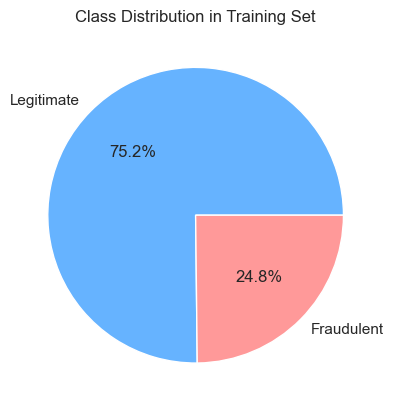

In [123]:
plt.pie(y_train.value_counts(), labels=['Legitimate', 'Fraudulent'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title('Class Distribution in Training Set')
plt.show()

### Unsupervised Model Training and Evaluation

K-Means

In [124]:
from sklearn.cluster import KMeans

k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
wcss_error = []

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    wcss_error.append(kmeans.inertia_)



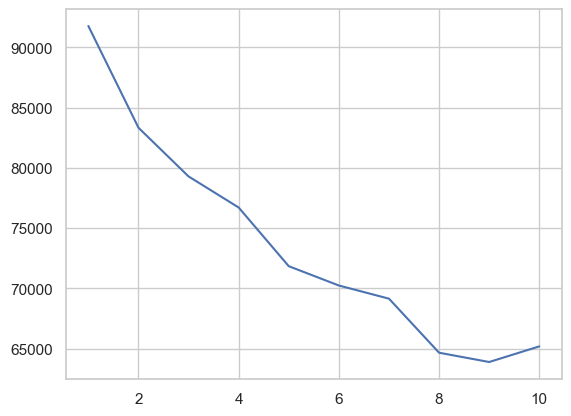

In [125]:
plt.plot(k_values, wcss_error)

In [126]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
pred = kmeans.fit_predict(X)

In [127]:
df['cluster'] = pred
df.head()

,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,device_ip_reputation,...,proxy_usage,is_fraudulent,ip_country,ip_city,ip_asn,ip_org,ip_is_datacenter,fraud_score,predicted_label,cluster
0,1.248676,1.435023,-1.422173,-0.866694,0.358776,-0.956623,-1.167139,0.749968,-1.342333,-0.242335,...,2.354677,0,0.886085,0.740814,1.171845,1.374353,-0.056659,3,0,1
1,-1.192051,0.720939,0.705554,-0.689967,-0.849619,1.381681,0.298029,1.526092,-0.591178,2.048170,...,-0.424687,0,0.760928,0.738640,-1.394498,-1.056693,-0.056659,1,0,0
2,1.248676,1.435023,-0.712931,-0.801053,-0.469838,1.237680,-0.469440,1.526092,0.136685,-0.242335,...,2.354677,0,0.886085,0.740814,1.171845,1.374353,-0.056659,3,0,1
3,1.248676,-0.707229,1.414797,1.153050,-0.711517,1.518825,0.856189,-0.414217,-1.569426,2.048170,...,-0.424687,0,0.760928,-2.206273,-0.437378,0.224127,-0.056659,0,0,0
4,-1.192051,0.720939,-0.003688,0.229017,1.532646,-1.374912,-1.585759,0.749968,-1.196761,-0.242335,...,-0.424687,0,0.886085,0.740814,1.171845,1.374353,-0.056659,0,0,0


In [128]:
print(df['cluster'].value_counts())


cluster
0    3705
1    1295
Name: count, dtype: int64


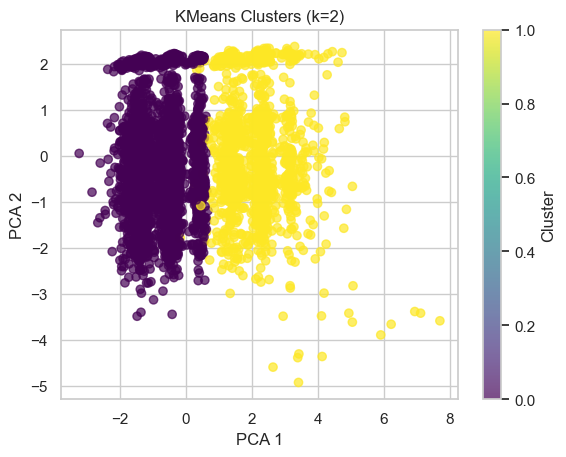

In [129]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
x_pca = pca.fit_transform(X)

plt.scatter(x_pca[:, 0], x_pca[:, 1], c=pred, cmap="viridis", alpha=0.7)
plt.title("KMeans Clusters (k=2)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.show()


In [130]:
from sklearn.metrics import silhouette_score
print("Silhouette Score:", silhouette_score(X, pred))

Silhouette Score: 0.1529782090607113


DBSCAN

In [90]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

for eps in [0.5, 1, 1.5, 2, 3]:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(x_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"eps={eps}, clusters={n_clusters}, unique={np.unique(labels)}")


eps=0.5, clusters=0, unique=[-1]
eps=1, clusters=0, unique=[-1]
eps=1.5, clusters=0, unique=[-1]
eps=2, clusters=24, unique=[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23]
eps=3, clusters=12, unique=[-1  0  1  2  3  4  5  6  7  8  9 10 11]


In [91]:
from sklearn.metrics import silhouette_score

for eps in [2, 3]:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(x_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters > 1:  # silhouette requires at least 2 clusters
        score = silhouette_score(x_scaled, labels)
        print(f"eps={eps}, clusters={n_clusters}, Silhouette={score:.3f}")
    else:
        print(f"eps={eps} not suitable (only {n_clusters} clusters).")

eps=2, clusters=24, Silhouette=-0.276
eps=3, clusters=12, Silhouette=-0.051


#### Save and Load Kmeans Model

In [136]:
# Save KMeans Model
import pickle

with open('Ensemble_Model/Base_Models/kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

In [137]:
# Load Model
with open('Ensemble_Model/Base_Models/kmeans_model.pkl', 'rb') as f:
    loaded_kmeans = pickle.load(f)

Sample Inputs

In [133]:
# --- Example Input ---
example_input = {
    "device_type": "Desktop",
    "browser": "Firefox",
    "operating_system": "Windows",
    "click_duration": 3.2,
    "scroll_depth": 60,
    "mouse_movement": 120,
    "keystrokes_detected": 40,
    "click_frequency": 7,
    "time_since_last_click": 72,
    "device_ip_reputation": "Good",
    "VPN_usage": 0,
    "proxy_usage": 1,
    "ip_country": "United States",
    "ip_city": "Los Angeles",
    "ip_asn": "AS15169",
    "ip_org": "Google LLC",
    "ip_is_datacenter": 0,
    "fraud_score": 3
}

example_df = pd.DataFrame([example_input])

In [134]:
# --- Clean and handle categorical features ---
categorical_cols = [
    "device_type", "browser", "operating_system",
    "device_ip_reputation", "ip_country", "ip_city",
    "ip_asn", "ip_org"
]

# Handle unseen labels gracefully
for col in categorical_cols:
    if "Unknown" not in label_encoders[col].classes_:
        label_encoders[col].classes_ = np.append(label_encoders[col].classes_, "Unknown")

    value = example_df[col].iloc[0]
    if value not in label_encoders[col].classes_:
        example_df[col] = ["Unknown"]
    example_df[col] = label_encoders[col].transform(example_df[col])

    print(f"Encoded {col}: {example_df[col].iloc[0]}")

Encoded device_type: 3
Encoded browser: 5
Encoded operating_system: 5
Encoded device_ip_reputation: 3
Encoded ip_country: 123
Encoded ip_city: 1418
Encoded ip_asn: 1228
Encoded ip_org: 1148


In [138]:
# --- Identify numeric columns ---
numeric_cols = [
    "device_type", "browser", "operating_system",
    "click_duration", "scroll_depth", "mouse_movement",
    "keystrokes_detected", "click_frequency",
    "time_since_last_click", "device_ip_reputation",
    "VPN_usage", "proxy_usage",
    "ip_country", "ip_city", "ip_asn", "ip_org",
     "ip_is_datacenter", "fraud_score"
]

# --- Apply same scaler as training (DO NOT FIT AGAIN) ---
example_df[numeric_cols] = scaler.fit_transform(example_df[numeric_cols])

# Reorder columns to match training data
example_df = example_df[numeric_cols]

# --- Make prediction ---
prediction = loaded_kmeans.predict(example_df)
print("✅ Prediction:", "Fraudulent" if prediction[0] == 1 else "Genuine")

✅ Prediction: Genuine
